In [3]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [4]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [5]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [6]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [7]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

title_release_movies = df_movies.title + df_movies.release_date.astype(str)
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies

title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [8]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [9]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [10]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [11]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [12]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [13]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [14]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [15]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [16]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [17]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

In [18]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with more than one country
df_movies_ratings_imdb['country_count'] = df_movies_ratings_imdb['countries'].str.len()
movies_1_country = df_movies_ratings_imdb[df_movies_ratings_imdb['country_count'] == 1.0]
movies_1_or_2_country = df_movies_ratings_imdb[(df_movies_ratings_imdb['country_count'] == 1.0) | (df_movies_ratings_imdb['country_count'] == 2.0)]

movies_1_country_size = movies_1_country.size
movies_1_or_2_country_size = movies_1_or_2_country.size
all_movies = df_movies_ratings_imdb.size

percent_one_country = movies_1_country_size/all_movies
percent_one_or_two_country = movies_1_or_2_country_size/all_movies

print(f"{percent_one_country} of our ratings-populated movie metadataset have only one country listed.")
print(f"{percent_one_or_two_country} of our ratings-populated movie metadataset have one or two countries listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = movies_1_country
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['country_count'], axis = 1)

0.8652437957663759 of our ratings-populated movie metadataset have only one country listed.
0.9617624272111563 of our ratings-populated movie metadataset have one or two countries listed.


In [19]:
# Evaluating movies with more than one genre
df_movies_ratings_imdb['genre_count'] = df_movies_ratings_imdb['genres'].str.len()
movies_1_genre = df_movies_ratings_imdb[df_movies_ratings_imdb['genre_count'] == 1.0]
movies_1_or_2_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0)]
movies_1_to_3_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0)]
movies_1_to_4_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0)]
movies_1_to_5_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0)]
movies_1_to_6_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0) | (df_movies_ratings_imdb['genre_count'] == 6.0)]

movies_1_genre_size = movies_1_genre.size
movies_1_or_2_genre_size = movies_1_or_2_genre.size
movies_1_to_3_genre_size = movies_1_to_3_genre.size
movies_1_to_4_genre_size = movies_1_to_4_genre.size
movies_1_to_5_genre_size = movies_1_to_5_genre.size
movies_1_to_6_genre_size = movies_1_to_6_genre.size
all_movies = df_movies_ratings_imdb.size

percent_one_genre = movies_1_genre_size/all_movies
percent_one_or_two_genre = movies_1_or_2_genre_size/all_movies
percent_one_to_three_genre = movies_1_to_3_genre_size/all_movies
percent_one_to_four_genre = movies_1_to_4_genre_size/all_movies
percent_one_to_five_genre = movies_1_to_5_genre_size/all_movies
percent_one_to_six_genre = movies_1_to_6_genre_size/all_movies

print(f"{percent_one_genre} of our ratings-populated movie metadataset have only one genre listed.")
print(f"{percent_one_or_two_genre} of our ratings-populated movie metadataset have one or two genres listed.")
print(f"{percent_one_to_three_genre} of our ratings-populated movie metadataset have one to three genres listed.")
print(f"{percent_one_to_four_genre} of our ratings-populated movie metadataset have one to four genres listed.")
print(f"{percent_one_to_five_genre} of our ratings-populated movie metadataset have one to five genres listed.")
print(f"{percent_one_to_six_genre} of our ratings-populated movie metadataset have one to six genres listed.")

0.19834782357528669 of our ratings-populated movie metadataset have only one genre listed.
0.3923919008694145 of our ratings-populated movie metadataset have one or two genres listed.
0.5690188036163022 of our ratings-populated movie metadataset have one to three genres listed.
0.720169839114988 of our ratings-populated movie metadataset have one to four genres listed.
0.8306808006701135 of our ratings-populated movie metadataset have one to five genres listed.
0.9043066347014818 of our ratings-populated movie metadataset have one to six genres listed.


In [20]:
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

In [21]:
df_movies_tmdb_ratings = df_movies_ratings_imdb.copy()

# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [22]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [23]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 32977 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [24]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

# Define imports for graphs and general settings

In [25]:
# bar race
import plotly.graph_objects as go
import plotly.express as px

# Choice Display
import ipywidgets as widgets
from ipywidgets import interact, SelectMultiple, Dropdown

# Continent Map
from src.data.continents_clusters import regions
from src.utils import add_features

# Comparison Average Genre Rating in 2 Regions
from IPython.display import display

In [26]:
# Genres Palette definition
n = 20
all_genres = (df_movies_tmdb_ratings['genres']
              .value_counts()
              .index.tolist())

genres_colors = [
    '#FF5733', '#FF8D1A', '#FFB300', '#FFEB3B', '#8BC34A', 
    '#4CAF50', '#009688', '#00BCD4', '#2196F3', '#3F51B5', 
    '#9C27B0', '#E91E63', '#F44336', '#FF5722', '#795548', 
    '#607D8B', '#8D6E63', '#FF9800', '#9E9D24', '#43A047'
]

genres_palette = dict(zip(all_genres, genres_colors))

# Regions Palette definition
all_regions = (df_movies_tmdb_ratings['region']
              .value_counts()
              .index.tolist())

regions_colors = ['#003366', '#4B0082', '#FF7F00', '#FFD700', '#FF5733', '#8A2BE2', '#00BFFF', '#C71585', '#228B22' ]
regions_palette = dict(zip(all_regions, regions_colors))

# Get all countries
all_countries = (df_movies_tmdb_ratings['countries']
              .value_counts()
              .index.tolist())

In [27]:
country_to_iso = {
    'United States of America': 'USA',
    'Israel': 'ISR',
    'Australia': 'AUS',
    'France': 'FRA',
    'Hungary': 'HUN',
    'Netherlands': 'NLD',
    'United Kingdom': 'GBR',
    'New Zealand': 'NZL',
    'South Africa': 'ZAF',
    'Spain': 'ESP',
    'Canada': 'CAN',
    'Romania': 'ROU',
    'Japan': 'JPN',
    'Hong Kong': 'HKG',
    'Germany': 'DEU',
    'West Germany': 'DEU',  # Same as Germany post-reunification
    'Italy': 'ITA',
    'India': 'IND',
    'Belgium': 'BEL',
    'South Korea': 'KOR',
    'Uruguay': 'URY',
    'Argentina': 'ARG',
    'Poland': 'POL',
    'Austria': 'AUT',
    'Brazil': 'BRA',
    'Finland': 'FIN',
    'Norway': 'NOR',
    'Cuba': 'CUB',
    'Ukraine': 'UKR',
    'Taiwan': 'TWN',
    'England': 'GBR',  # Part of the United Kingdom
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Ireland': 'IRL',
    'Mexico': 'MEX',
    'Czechoslovakia': 'CZE',  # Note: split into Czech Republic and Slovakia
    'Estonia': 'EST',
    'Luxembourg': 'LUX',
    'Denmark': 'DNK',
    'Iceland': 'ISL',
    'Iran': 'IRN',
    'Singapore': 'SGP',
    'Lebanon': 'LBN',
    'Czech Republic': 'CZE',
    'Serbia': 'SRB',
    'Scotland': 'GBR',  # Part of the United Kingdom
    'Portugal': 'PRT',
    'Greece': 'GRC',
    'Zimbabwe': 'ZWE',
    'Turkey': 'TUR',
    'Vietnam': 'VNM',
    'Peru': 'PER',
    'Tunisia': 'TUN',
    'Morocco': 'MAR',
    'Slovak Republic': 'SVK',  # Now Slovakia
    'Thailand': 'THA',
    'Kuwait': 'KWT',
    'Puerto Rico': 'PRI',
    'Yugoslavia': 'YUG',  # Former Yugoslavia, no longer exists
    'Georgian SSR': 'GEO',  # Part of the former Soviet Union
    'Mali': 'MLI',
    'Colombia': 'COL',
    'Republic of Macedonia': 'MKD',  # Now North Macedonia
    'Jamaica': 'JAM',
    'Weimar Republic': 'DEU',  # Historical, same as Germany
    'Senegal': 'SEN',
    'Qatar': 'QAT',
    'Bolivia': 'BOL',
    'Monaco': 'MCO',
    'Philippines': 'PHL',
    'Venezuela': 'VEN',
    'Egypt': 'EGY',
    'Chile': 'CHL',
    'Bahamas': 'BHS',
    'Cameroon': 'CMR',
    'German Democratic Republic': 'DEU',  # Historical, same as Germany
    'Bulgaria': 'BGR',
    'United Arab Emirates': 'ARE',
    'Algeria': 'DZA',
    'Malaysia': 'MYS',
    'Palestinian territories': 'PSE',  # Palestinian territories
    'Bosnia and Herzegovina': 'BIH',
    'Bangladesh': 'BGD',
    'Iraq': 'IRQ',
    'Slovakia': 'SVK',
    'Slovenia': 'SVN',
    'Croatia': 'HRV',
    'Burkina Faso': 'BFA',
    'Northern Ireland': 'GBR',  # Part of the United Kingdom
    'Wales': 'GBR',  # Part of the United Kingdom
    'Lithuania': 'LTU',
    'Nepal': 'NPL',
    'Socialist Federal Republic of Yugoslavia': 'YUG',  # Former Yugoslavia
    'Libya': 'LBY',
    'Serbia and Montenegro': 'SCG',  # Former country
    'Indonesia': 'IDN',
    'Haiti': 'HTI',
    'Afghanistan': 'AFG',
    'Mandatory Palestine': 'PSE',  # Palestinian territories
    'Federal Republic of Yugoslavia': 'SCG',  # Former country
    'Isle of Man': 'IMN',
    'Ukrainian SSR': 'UKR',  # Part of the former Soviet Union
    'Kingdom of Great Britain': 'GBR',  # Historical, same as United Kingdom
    'Zambia': 'ZMB',
    'Kenya': 'KEN',
    'Mongolia': 'MNG',
    'Albania': 'ALB',
    'Panama': 'PAN',
    'Aruba': 'ABW',
    'Montenegro': 'MNE',
    'Malta': 'MLT',
    'Democratic Republic of the Congo': 'COD'
}

# Introduction Graphs 

## GRAPH: World Map with Mean Rating, per Country, over Time

In [28]:
# Plot World Map Function
def plot_world_map(selected_genres):
    if not selected_genres:
        return 
    
    genre = selected_genres
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(lambda x: x is not None and genre in x)]
    df_world_map = (genre_movies
                    .groupby(['release_date', 'countries', 'region'])
                    .agg({'averageRating': 'mean'})
                    .reset_index()
                    .rename(columns={'release_date': 'Year', 'countries': 'Country', 'region': 'Region', 'averageRating': 'Average Rating'}))

    # Create a full range of years and all genre combinations
    min_year, max_year = df_world_map['Year'].min(), df_world_map['Year'].max()
    all_years = pd.Series(range(min_year, max_year + 1), name='Year')
    all_countries = df_world_map['Country'].unique()
    all_combinations = pd.MultiIndex.from_product([all_years, all_countries], names=['Year', 'Country']).to_frame(index=False)

    # Merge with the existing dataframe and fill missing values
    df_world_map_full = all_combinations.merge(df_world_map, on=['Year', 'Country'], how='left')

    df_world_map_full['Average Rating'] = df_world_map_full.groupby('Country')['Average Rating'].ffill().fillna(0)
    df_world_map_full['ISO_alpha'] = df_world_map_full['Country'].map(country_to_iso)

    country_to_region = add_features.map_regions(regions)
    df_world_map_full['Region'] = df_world_map_full['Country'].map(country_to_region)

    df_world_map_full['scaled_mean_rating'] = df_world_map_full['Average Rating'].apply(
        lambda x: x if x == 0 else (x - df_world_map_full['Average Rating'].min()) * 100
    )

    df_world_map_filtered = df_world_map_full[df_world_map_full['Average Rating'] != 0]

    # Create Geographic Heatmap
    fig = px.choropleth(df_world_map_filtered, 
                        locations="ISO_alpha",  
                        color="Average Rating",  
                        hover_name="Country", 
                        animation_frame="Year",
                        color_continuous_scale="RdBu",  
                        projection="natural earth",
                        range_color=[1, 10])

    # Map layout
    fig.update_layout(
        title={'text': 'Average Rating variation, per Country, over Time',
            'font': {'size': 24, 'family': 'Arial', 'weight': 'bold'}, 
            'x': 0.5,
            'y': 0.95,
            'xanchor':'center',
            'yanchor':'top'},
        geo=dict(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="whitesmoke"),
        width=1000, 
        height=600)

    fig.show()


In [29]:
# Dropdown for selecting one genre
genre_selector = Dropdown(
    options=all_genres,
    value=None,  # Default value
    description='Genres',
    disabled=False
)

# Interface
interact(plot_world_map, selected_genres=genre_selector)


interactive(children=(Dropdown(description='Genres', options=('Drama', 'Comedy', 'Romance', 'Black-and-white',…

<function __main__.plot_world_map(selected_genres)>

## GRAPH: Movies distribution by release date, all movies

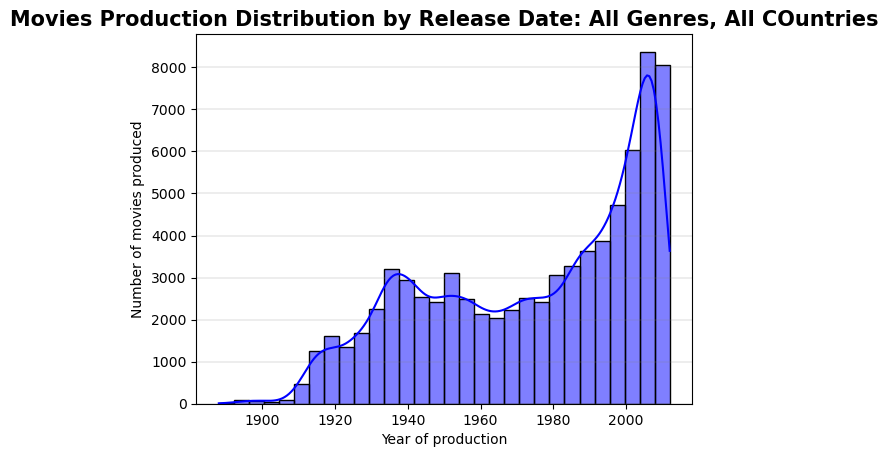

In [30]:
plt.title(f'Movies Production Distribution by Release Date: All Genres, All COuntries', fontsize=15, fontweight='bold')
sns.histplot(df_movies_tmdb_ratings['release_date'], kde=True, color='blue', bins=30)        # Set labels
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True, which='both', axis='y', linestyle='-', color='gray', linewidth=0.2)
plt.show()

## GRAPH: Movies distribution by release date, all genres

In [31]:
# Genre Distribution Plot Function
# Plot function
def plot_selected_genres(selected_genre):

    selected_genre = selected_genre[0] if isinstance(selected_genre, tuple) else selected_genre
        
    plt.title(f'Movies Production Distribution by Release Date: {selected_genre}, All countries', fontsize=15, fontweight='bold')

    # Filter for the genre
    genre_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'] == selected_genre]

    # Get color
    hist_color = genres_palette.get(selected_genre)

    # Plot histogram
    sns.histplot(genre_movies['release_date'], kde=True, color=hist_color, bins=30)

    # Set labels
    plt.xlabel('Year of production')
    plt.ylabel('Number of movies produced')
    plt.grid(True, which='both', axis='y', linestyle='-', color='gray', linewidth=0.2)

    plt.tight_layout()
    plt.show()

In [32]:
# Dropdown for selecting one genre
genre_selector = SelectMultiple(
    options=all_genres,
    value=all_genres[:1],
    description='Movie Genre',
    disabled=False
)

# Interface
interact(plot_selected_genres, selected_genre=genre_selector)

interactive(children=(SelectMultiple(description='Movie Genre', index=(0,), options=('Drama', 'Comedy', 'Roman…

<function __main__.plot_selected_genres(selected_genre)>

## GRAPH: Movies distribution by release date, with the possibility to select a genre

In [33]:
# Genre Distribution Plot Function
# Plot function
def plot_selected_genres_countries(selected_genre, selected_country):

    selected_genre = selected_genre[0] if isinstance(selected_genre, tuple) else selected_genre
    selected_country = selected_country[0] if isinstance(selected_country, tuple) else selected_country
        
    plt.title(f'Movies Production Distribution by Release Date: {selected_genre}, in {selected_country}', fontsize=15, fontweight='bold')

    # Filter for the country 
    country_movies = df_movies_tmdb_ratings[df_movies_tmdb_ratings['countries'] == selected_country]

    # Filter for the genre
    genre_movies = country_movies[country_movies['genres'] == selected_genre]

    # Get color
    hist_color = genres_palette.get(selected_genre)

    # Plot histogram
    sns.histplot(genre_movies['release_date'], kde=True, color=hist_color, bins=30)

        # Set labels
    plt.xlabel('Year of production')
    plt.ylabel('Number of movies produced')
    plt.grid(True, which='both', axis='y', linestyle='-', color='gray', linewidth=0.2)

    plt.tight_layout()
    plt.show()

In [34]:
# Dropdown for selecting one genre
genre_selector = SelectMultiple(
    options=all_genres,
    value=all_genres[:1],
    description='Movie Genre',
    disabled=False
)

# Dropdown for selecting one country
country_selector = SelectMultiple(
    options=all_countries,
    value=all_countries[:1],
    description='Country',
    disabled=False
)

# Interface
interact(plot_selected_genres_countries, selected_genre=genre_selector, selected_country= country_selector)

interactive(children=(SelectMultiple(description='Movie Genre', index=(0,), options=('Drama', 'Comedy', 'Roman…

<function __main__.plot_selected_genres_countries(selected_genre, selected_country)>

## GRAPH: Movie Race: Number of Movies Produced per Genre Over Time

In [35]:
# Group by 'release_date' and 'genres', and count the number of movies
df_bar_race = (df_movies_tmdb_ratings
               .groupby(['release_date', 'genres'])
               .size()
               .reset_index(name='Count')
               .rename(columns={'release_date': 'Year', 'genres': 'Genre'}))

# Sort by 'Year' and 'Genre' and apply cumulative sum
df_bar_race.sort_values(by=['Genre', 'Year'], inplace=True)
df_bar_race['Count'] = df_bar_race.groupby('Genre')['Count'].cumsum()

# Create a full range of years and all genre combinations
#df_bar_race['Year'] = df_bar_race['Year'].dt.year

min_year, max_year = df_bar_race['Year'].min(), df_bar_race['Year'].max()

all_years = pd.Series(range(min_year, max_year + 1), name='Year')
all_combinations = pd.MultiIndex.from_product([all_years, all_genres], names=['Year', 'Genre']).to_frame(index=False)

# Merge with the existing dataframe and fill missing values
df_bar_race_full = all_combinations.merge(df_bar_race, on=['Year', 'Genre'], how='left')
df_bar_race_full['Count'] = df_bar_race_full.groupby('Genre')['Count'].ffill().fillna(0)


# Plot the bar race 
fig = px.bar(
    df_bar_race_full,
    x='Count',
    y='Genre',
    color='Genre',
    animation_frame='Year',
    orientation='h',
    labels={'Count': 'Number of Movies', 'Genre': 'Genre'},
    text_auto = True,
    template='plotly_white',
    color_discrete_map = genres_palette
)

# Update traces and layout
fig.update_traces(textposition = 'inside', textfont_size = 50)
fig.update_layout(
    title={'text': 'Number of Movies Produced per Genre Over Time',
           'font': {'size': 24, 'family': 'Arial', 'weight': 'bold'}, 
           'x': 0.5,
           'y': 0.95,
           'xanchor':'center',
           'yanchor':'top'},
    height=600,  
    width=1600   
)

# Set the duration
fig.update_layout(
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]
        }]
    }]
)


fig.show()



## GRAPH: Heat map with rating distribution per genre, from jake's code

In [36]:
df_genres_heatmap = pd.crosstab(df_movies_tmdb_ratings['genres'],df_movies_tmdb_ratings['averageRating'].apply(lambda x: round(x*2)/2), normalize='index')

# Create the heatmap with Plotly
fig = px.imshow(
    df_genres_heatmap,
    color_continuous_scale='RdBu',
    labels={'x': 'Average Rating', 'y': 'Genres'},  
    title='Rating Distribution Over Genres'
)

# Customize the layout
fig.update_layout(
    title={'text': 'Rating Distribution Over Genres',
           'font': {'size': 24, 'weight': 'bold'}, 'x': 0.5, 'xanchor': 'center'},
    xaxis_title='Mean Rating',
    yaxis_title='Genres',
    template='plotly_white',
    height=800,  
    width=800,

    xaxis=dict(
        tickmode='linear',  
        tickvals=df_genres_heatmap.columns.tolist() 
    ),

    coloraxis_colorbar=dict(
        title='Frequency', 
    )
)

fig.update_traces(
    hovertemplate='Frequency=%{z}<br>Genre=%{y}<br>Rating Binned=%{x}'  
)

# Show the figure
fig.show()


In [37]:
# Filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_tmdb_ratings_regionfilled = df_movies_tmdb_ratings.copy()
for genre in all_genres:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in all_regions:
            if i not in regions_with_genre:
                    new_row = {"region": i, "genres": genre, "averageRating": 0.0}
                    df_movies_tmdb_ratings_regionfilled = pd.concat([df_movies_tmdb_ratings_regionfilled, pd.DataFrame([new_row])], ignore_index=True)
# Identifying if any country does not have a particular genre again, which shouldn't be the case
for genre in all_genres:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in all_regions:
            if i not in regions_with_genre:
                print(f"The geographical region {i} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one Drama movie.
Every region has at least one Comedy movie.
Every region has at least one Romance movie.
Every region has at least one Black-and-white movie.
Every region has at least one Action movie.
Every region has at least one Thriller movie.
Every region has at least one Crime fiction movie.
Every region has at least one Indie movie.
Every region has at least one Short movie.
Every region has at least one World cinema movie.
Every region has at least one Action/adventure movie.
Every region has at least one Horror movie.
Every region has at least one Adventure movie.
Every region has at least one Family movie.
Every region has at least one Musical movie.
Every region has at least one Documentary movie.
Every region has at least one Romantic drama movie.
Every region has at least one Mystery movie.
Every region has at least one Romantic comedy movie.
Every region has at least one Silent movie.


In [38]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings_regionfilled.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in all_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per region per genre over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for genre in all_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    region_mean_ratings = genre_df.groupby(["region", "decade"])

    region_mean_ratings_size = region_mean_ratings.size().sort_index()
    region_mean_ratings_regions_average = region_mean_ratings.mean("averageRating").sort_index()
    region_mean_ratings_regions_std = region_mean_ratings["averageRating"].std().sort_index()  
    region_mean_ratings_regions_stderr = region_mean_ratings_regions_std / np.sqrt(region_mean_ratings_size) 
    
    # Storing the mean ratings and confidence intervals for the region in the genre across decades
    region_means = np.zeros((20, 6))
    region_CI = np.zeros((20, 6))

    for i, region in enumerate(all_regions):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if region_mean_ratings_size.loc[(region, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = region_mean_ratings_regions_average.loc[(region, decade), "averageRating"]
                region_CI[i][j] = region_mean_ratings_regions_stderr.loc[(region, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[genre] = region_means
    confidence_intervals[genre] = region_CI

In [64]:
# Define the function to compare the avergae rating of a specific genre in 2 regions
def plot_selected_genres_regions(selected_genre, first_region, second_region):

    # element must be list or tuple
    selected_genre = selected_genre[0] if isinstance(selected_genre, (list, tuple)) else selected_genre
    first_region = first_region[0] if isinstance(first_region, (list, tuple)) else first_region
    second_region = second_region[0] if isinstance(second_region, (list, tuple)) else second_region

    # cleans the graph
    fig.data = []

    means = mean_ratings[selected_genre]        
    stderrs = confidence_intervals[selected_genre]

    # Dictionary to map regions to indeces
    region_indices = {region: idx for idx, region in enumerate(all_regions)}

    # Colori distinti per le due regioni
    region_colors = ['blue', 'lightgreen']

    for i, region in enumerate([first_region, second_region]):
            idx = region_indices[region]
            mean = means[idx]
            stderr = stderrs[idx]

            # Filtraggio dei valori non nulli
            mask = np.array(mean) != 0
            filtered_means = np.array(mean)[mask]
            filtered_stderrs = np.array(stderr)[mask]
            filtered_decades = np.array(decades)[mask]

            # Mappatura delle decadi a interi
            decade_map = {decade: int(decade) for decade in decades}
            filtered_decades_as_int = [decade_map[d] for d in filtered_decades]

            # Ordinamento per decade
            sorted_indices = np.argsort(filtered_decades_as_int)
            filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
            filtered_means = filtered_means[sorted_indices]
            filtered_stderrs = filtered_stderrs[sorted_indices]

            # Aggiunta della traccia per ogni regione
            fig.add_trace(go.Scatter(
                x=filtered_decades,
                y=filtered_means,
                mode='lines+markers',
                line=dict(color=region_colors[i]),
                error_y=dict(type='data', array=filtered_stderrs, visible=True),
                name=f"{selected_genre} - {region}"
            ))




In [67]:
# Dropdown for selecting one genre
genre_selector = SelectMultiple(
    options=all_genres,
    value=[all_genres[0]],
    description='Movie Genre',
    disabled=False
)

# Dropdown for selecting one genre
first_region_selector = SelectMultiple(
    options=all_regions,
    value=[all_regions[0]],
    description='First Region',
    disabled=False
)

# Dropdown for selecting one genre
second_region_selector = SelectMultiple(
    options=all_regions,
    value=[all_regions[1]],
    description='Second Region',
    disabled=False
)

fig = go.FigureWidget()
fig.update_layout(
    title={'text': 'Average Rating Evolution for the Selected Genre',
           'font': {'size': 24, 'weight': 'bold'}, 'x': 0.5, 'xanchor': 'center'},
    xaxis_title="Decade",
    yaxis_title="Rating",
    legend_title="Regions"
)
display(fig)

# Interface
interact(plot_selected_genres_regions, selected_genre=genre_selector, first_region= first_region_selector, second_region = second_region_selector)

FigureWidget({
    'data': [],
    'layout': {'legend': {'title': {'text': 'Regions'}},
               'template': '...',
               'title': {'font': {'size': 24, 'weight': 'bold'},
                         'text': 'Average Rating Evolution for the Selected Genre',
                         'x': 0.5,
                         'xanchor': 'center'},
               'xaxis': {'title': {'text': 'Decade'}},
               'yaxis': {'title': {'text': 'Rating'}}}
})

interactive(children=(SelectMultiple(description='Movie Genre', index=(0,), options=('Drama', 'Comedy', 'Roman…

<function __main__.plot_selected_genres_regions(selected_genre, first_region, second_region)>